In [2]:
# Load data first
# Data Credit: Alvin Lo, Ning Liu, Tony Tan, Ziqing Guo
# MATH 5470, HKUST
import os
from google.colab import drive
drive.mount("/content/drive")

os.chdir("/content/drive/My Drive/Reimaging_Price_Trends/model_20")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# Import important libraries
import pandas as pd
import numpy as np
import os
import torch.nn as nn
import functools as partial
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from typing import Optional, Callable
from torch._dynamo import config
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import re
import scipy.stats
import torch
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import numpy as np

random.seed(10)

In [13]:
import torch
print(torch.__version__)  # Verify PyTorch is loaded
print(hasattr(torch._dynamo, 'config'))  # Check if attribute exists

2.6.0+cu124
True


# Data Information

label_train: store all the data and information associated with each row

length_train: store how much data has in 1 year

In [7]:
# Take label train and see how it is

label_train = pd.read_hdf('./label_train.h5', key = 'label_data')
label_train

,Date,StockID,MarketCap,Ret_5d,Ret_20d,Ret_60d,Ret_month,EWMA_vol
0,1993-01-29,10001,-15120.000,3.240260e-07,0.035714,0.065641,0.017857,0.000417
1,1993-02-26,10001,15390.000,-8.771723e-03,0.002584,0.073561,0.011456,0.000342
2,1993-03-31,10001,15318.750,-8.771614e-03,0.105263,0.117841,0.070175,0.000471
3,1993-04-30,10001,-16393.750,3.278655e-02,-0.008199,0.085991,-0.008199,0.000389
4,1993-05-28,10001,-16259.375,2.809882e-02,0.086608,0.136763,0.103326,0.000566
...,...,...,...,...,...,...,...,...
694866,1999-08-31,93316,-26389.625,-5.109452e-02,-0.080293,-0.051093,-0.167884,0.000972
694867,1999-09-30,93316,21959.250,2.193014e-02,-0.052630,0.315794,-0.035085,0.000582
694868,1999-10-29,93316,21188.750,9.091081e-02,0.272728,1.163636,0.236365,0.001178
694869,1999-11-30,93316,-26197.000,1.470503e-02,0.397057,0.794113,0.514704,0.002239


In [10]:
# Take length train and see how it is

length_train = pd.read_hdf("./length_train.h5", key = "length_data")
length_train

,0
1993,85644
1994,94750
1995,97707
1996,102974
1997,107311
1998,106201
1999,100284


In [11]:
# From Dacheng's Website
IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}

# CNN Model

In [14]:
class CNN(nn.Module):
  def __init__(self, num_class = 2, initial_filter = 64, filter_sizes = (5, 3), pooling = (2, 1), dilation = (2, 1), stride = (2, 1), dropout = 0.5, batch_normalized = True, activation = 'leaky_relu'):
    super().__init__()

    # Some configurations
    self.num_class = num_class

    # Padding so that the output dimension is similar to input dimension
    height_pad = (filter_sizes[0] - 1) // 2
    width_pad = (filter_sizes[1] - 1) // 2
    padding = (height_pad, width_pad)

    # LeakyReLU Activation Function
    if activation == 'leaky_relu':
      self.activation = nn.LeakyReLU(negative_slope = 0.01, inplace = True)

    else:
      self.activation = nn.ReLU(inplace = True)

    # Convolutional Layers
    self.conv1 = nn.Conv2d(1, initial_filter, kernel_size = filter_sizes, padding = padding, stride = (2, 1), dilation = (2, 1))
    self.conv2 = nn.Conv2d(initial_filter, initial_filter * 2, kernel_size = filter_sizes, padding = padding, stride = (1, 1))
    self.conv3 = nn.Conv2d(initial_filter * 2, initial_filter * 4, kernel_size = filter_sizes, padding = padding, stride = (1, 1))

    # Batch Normalization Layers
    if batch_normalized:
      self.bn1 = nn.BatchNorm2d(initial_filter)
      self.bn2 = nn.BatchNorm2d(initial_filter * 2)
      self.bn3 = nn.BatchNorm2d(initial_filter * 4)

    self.batch_normalized = batch_normalized

    # Pooling Layers
    self.pool = nn.MaxPool2d(kernel_size = pooling, stride = pooling)

    # Classifier
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(46080, num_class)

    # Initialize weights
    self._init_weights()

  def _init_weights(self):
    for m in self.modules():
      # Check whether it is a convolutional layer or a fully connected layer
      if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)

  def forward(self, x):
    # 1st Block
    x = self.conv1(x)
    if self.batch_normalized:
      x = self.bn1(x)

    x = self.activation(x)
    x = self.pool(x)

    # 2nd Block
    x = self.conv2(x)
    if self.batch_normalized:
      x = self.bn2(x)

    x = self.activation(x)
    x = self.pool(x)

    # 3rd Block
    x = self.conv3(x)
    if self.batch_normalized:
      x = self.bn3(x)

    x = self.activation(x)
    x = self.pool(x)

    # Classifer Block
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc(x)

    return x


In [16]:
# Check GPU environment

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
use_gpu = torch.cuda.is_available()
use_gpu

True

In [17]:
# Hyperparameters
target_label = "Ret_20d"

learning_rate = 1e-5
BATCH_SIZE = {"train": 128, "test": 128}
momentum = 0.9
num_epochs = 50
patience = 2
pin_memory = True
num_workers = 2

# Load images

In [18]:
# Since all years are saved to 1993, we would have
year = 1993
Images = np.memmap(os.path.join("monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"),
                   dtype = np.uint8, mode = 'r+').reshape(-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])

label_train = label_train.reset_index().drop('index', axis = 1)

In [19]:
# Check label_train
label_train

,Date,StockID,MarketCap,Ret_5d,Ret_20d,Ret_60d,Ret_month,EWMA_vol
0,1993-01-29,10001,-15120.000,3.240260e-07,0.035714,0.065641,0.017857,0.000417
1,1993-02-26,10001,15390.000,-8.771723e-03,0.002584,0.073561,0.011456,0.000342
2,1993-03-31,10001,15318.750,-8.771614e-03,0.105263,0.117841,0.070175,0.000471
3,1993-04-30,10001,-16393.750,3.278655e-02,-0.008199,0.085991,-0.008199,0.000389
4,1993-05-28,10001,-16259.375,2.809882e-02,0.086608,0.136763,0.103326,0.000566
...,...,...,...,...,...,...,...,...
694866,1999-08-31,93316,-26389.625,-5.109452e-02,-0.080293,-0.051093,-0.167884,0.000972
694867,1999-09-30,93316,21959.250,2.193014e-02,-0.052630,0.315794,-0.035085,0.000582
694868,1999-10-29,93316,21188.750,9.091081e-02,0.272728,1.163636,0.236365,0.001178
694869,1999-11-30,93316,-26197.000,1.470503e-02,0.397057,0.794113,0.514704,0.002239


In [21]:
# Check Images
type(Images)

numpy.memmap

In [27]:
raw_labels = np.sign(label_train[target_label].mask(label_train[target_label] == 0).dropna())

raw_labels[raw_labels < 0] = 0
classes = raw_labels.unique()
classes

array([1., 0.])

In [28]:
raw_labels

,Ret_20d
0,1.0
1,1.0
2,1.0
3,0.0
4,1.0
...,...
694866,0.0
694867,0.0
694868,1.0
694869,1.0


In [29]:
annotations = raw_labels.reset_index().rename(columns = {"index": "img_name", target_label: "label"})

In [31]:
# Check raw_labels again
annotations

,img_name,label
0,0,1.0
1,1,1.0
2,2,1.0
3,3,0.0
4,4,1.0
...,...,...
689174,694866,0.0
689175,694867,0.0
689176,694868,1.0
689177,694869,1.0


In [33]:
# We will construct a CNNDataset

class CNNDataset(Dataset):
  def __init__(self, Images_map, annotations, transform = None):
    self.annotations = annotations
    self.transform = transform
    self.Images = Images_map

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):

    img_id = self.annotations.iloc[index, 0]
    img = torch.from_numpy(self.Images[[img_id]]).type(torch.float)
    y_label = torch.tensor((self.annotations.iloc[index, 1])).type(torch.long)

    if self.transform is not None:
      img = self.transform(img)

    return (img, y_label)

In [35]:
# PyTorch necessary preparations

train_size = int(len(annotations) * 0.7)
val_size = len(annotations) - train_size

dataset = CNNDataset(Images, annotations)

# Random split training data and validation data
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create trainloader and valloader
trainloader = DataLoader(dataset = train_set, batch_size = 128, shuffle = True, num_workers = num_workers, pin_memory = pin_memory)
valloader = DataLoader(dataset = val_set, batch_size = 128, shuffle = False, num_workers = num_workers, pin_memory = pin_memory)

loaders = {"train": trainloader, "val": valloader}

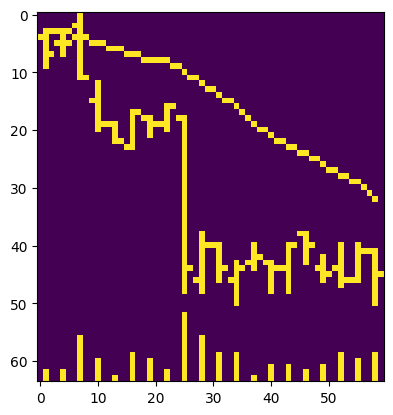

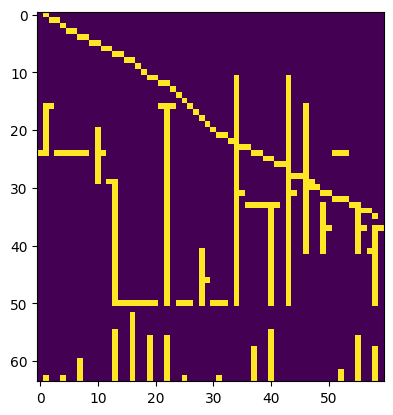

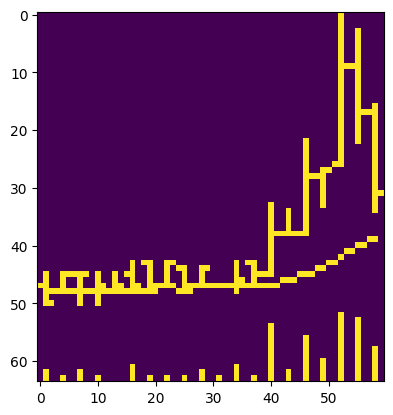

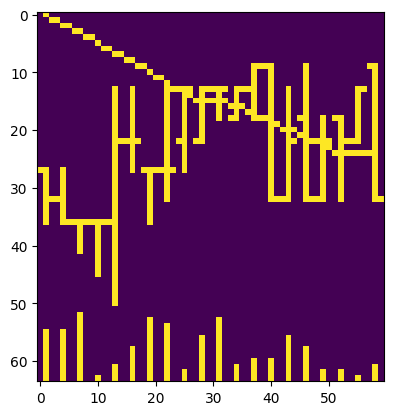

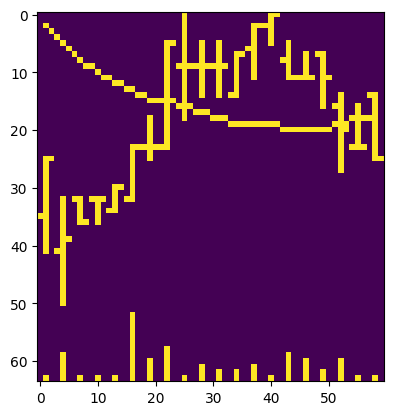

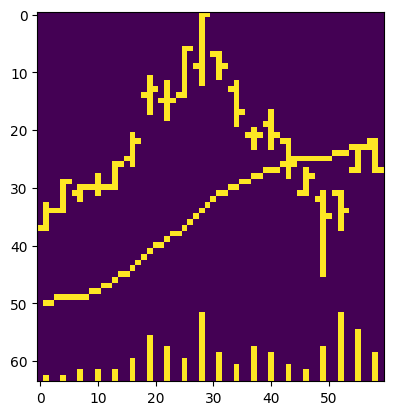

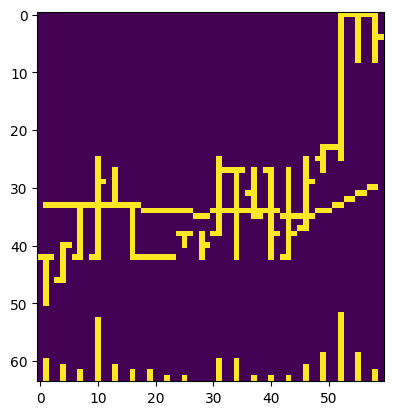

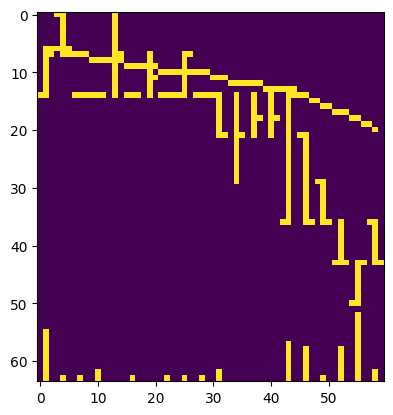

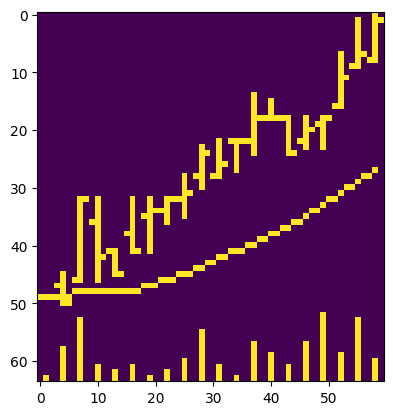

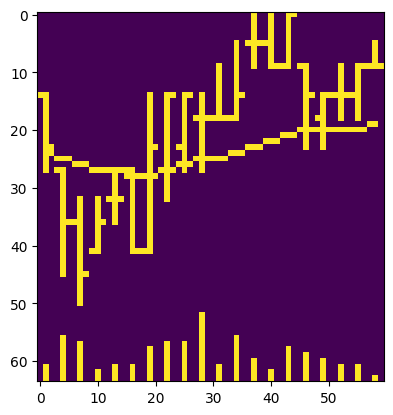

In [36]:
# Check some images
dataiter = iter(trainloader)
images, labels = next(iter(trainloader))

from matplotlib.pyplot import imshow
from matplotlib.pyplot import show
for img in images[:10]:
  imshow(img[0])
  show()

In [38]:
# Create a class to help track metrics
class AverageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n = 1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

In [39]:
def accuracy(model_outputs, true_labels, top_ks=(1,)):
  max_k = max(top_ks)  # Highest k we need to check
  batch_size = true_labels.size(0)

  # Get predicted class indices (sorted from most to least probable)
  _, predicted_classes = model_outputs.topk(max_k, dim=1, sorted=True)
  # predicted_classes shape: [batch_size, max_k]

  # Compare predictions to ground truth
  correct_predictions = predicted_classes == true_labels.view(-1, 1)
  # correct_predictions shape: [batch_size, max_k] (boolean matrix)

  accuracy_results = []
  for k in top_ks:
      # Count how many times true label appears in top k predictions
      correct_in_top_k = correct_predictions[:, :k].sum().float()
      accuracy_percent = correct_in_top_k * (100.0 / batch_size)
      accuracy_results.append(accuracy_percent)

  return accuracy_results

In [43]:
# Define loss function

criterion = nn.CrossEntropyLoss()

In [ ]:
for seed in range(0, 1):
  # Initialize logging structure
  log = {
      'num_params': [],
      'train_loss': [],
      'train_error': [],
      'test_loss': [],
      'test_error': []
  }
  log_saver = log  # Reference to the log dictionary
  num_epochs = 50
  print(f'Seed {seed}')
  torch.manual_seed(seed)  # Set random seed for reproducibility
  # Model initialization
  model = CNN()  # Create model instance
  model_name = 'Baseline_GPU'  # Base name for saving outputs
  # GPU setup if available
  if use_gpu:
      print('Using GPU')
      device = torch.device("cuda:2" if use_gpu else "cpu")
      model = model.cuda()  # Move model to GPU
  name = f'{model_name}_{seed}'  # Unique identifier for this run
  # Training initialization
  since = time.time()  # Start timer
  steps = 0
  last_loss = 100  # Initialize for early stopping
  trigger_times = 0  # Counter for early stopping
  # Optimizer setup
  optimizer = optim.Adam(model.parameters(), lr = learning_rate)
  number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  log['num_params'].append(number_params)
  print(f'Total trainable parameters: {number_params}')
  # Main training loop
  for epoch in range(num_epochs):
      print(f'Epoch {epoch + 1}/{num_epochs}')
      print('-' * 10)
      # Phase can be 'train' or 'test'
      for phase in ['train', 'test']:
          # Initialize metrics trackers
          loss_meter = AverageMeter()
          acc_meter = AverageMeter()
          # Set model mode
          model.train(phase == 'train')
          # Get appropriate data loader
          loader = loaders['train' if phase == 'train' else 'val']
          # Batch processing
          for i, (inputs, labels) in enumerate(loader):
              # Normalize inputs if needed
              print(f"i: {i}")
              normalize = True
              if normalize:
                  inputs /= 255
              # Move data to GPU if available
              if use_gpu:
                  inputs = inputs.cuda()
                  labels = labels.cuda()
              # Reset gradients
              optimizer.zero_grad()
              # Forward pass
              outputs = model(inputs)
              # Get predictions
              _, preds = torch.max(outputs.data, 1)
              # Calculate loss
              loss = criterion(outputs, labels)
              # Backward pass and optimize only in training phase
              if phase == 'train':
                  loss.backward()
                  optimizer.step()
                  steps += 1
              # Update metrics
              batch_size = outputs.size(0)
              loss_meter.update(loss.item(), batch_size)
              acc_meter.update(accuracy(outputs.data, labels.data)[0].item(), batch_size)
          # Calculate epoch metrics
          epoch_loss = loss_meter.avg
          epoch_error = 1 - acc_meter.avg / 100
          # Log results
          if phase == 'train':
              log_saver['train_loss'].append(epoch_loss)
              log_saver['train_error'].append(epoch_error)
          else:
              log_saver['test_loss'].append(epoch_loss)
              log_saver['test_error'].append(epoch_error)
          # Print progress
          print(f'{phase} loss: {epoch_loss:.4f}; error: {epoch_error:.4f}')
          print(f'Processed batches: {i}')
      # Periodic model saving
      if epoch % 100 == 0 or epoch == num_epochs - 1:
          print('Saving checkpoint...')
          state = {
              'net': model.state_dict(),
              'epoch': epoch,
              'log': log_saver
          }
          # Create directory if needed
          os.makedirs(f'./checkpoint_CNN/{model_name}', exist_ok=True)
          torch.save(state, f'./checkpoint_CNN/{model_name}/{name}.t7')
      # Early stopping check
      print(f'Cycle completed for {phase}, total samples: {loss_meter.count}')
      current_loss = epoch_loss
      if current_loss >= last_loss:
          trigger_times += 1
          print(f'Trigger times: {trigger_times}')
          if trigger_times >= patience:
              print('Early stopping triggered!')
              break
      else:
          print('Trigger times: 0')
          trigger_times = 0
      last_loss = current_loss
  # Final cleanup and saving
  time_elapsed = time.time() - since
  print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  # Save final model
  final_state = {
      'net': model.state_dict(),
      'epoch': epoch,
      'log': log_saver
  }
  torch.save(final_state, f'./checkpoint_CNN/{model_name}/{name}_final.t7')

In [49]:
def plot(log, result_dir):
  fontdict = {'size': 30}
  def get_fig(i, title):
      fig = plt.figure(i, figsize=(20, 10))
      ax = fig.add_subplot(111)
      #plt.title(title, fontsize=30, y=1.04)
      plt.xticks(fontsize=20)
      plt.yticks(fontsize=20)
      return fig, ax
  fig1, ax1 = get_fig(1, 'Loss on Cifar10')
  fig2, ax2 = get_fig(2, 'Error on Cifar10')
  ax1.plot(log['train_loss'],'b', linewidth=3, label='training')
  ax1.plot(log['test_loss'],'r', linewidth=3, label='test')
  ax1.set_ylabel('loss',fontdict=fontdict)
  ax2.plot(log['train_error'],'b', linewidth=3, label='training')
  ax2.plot(log['test_error'],'r', linewidth=3, label='test')
  ax2.set_ylabel('error',fontdict=fontdict)
  for ax in [ax1, ax2]:
      ax.set_xlabel('Number of epochs', fontdict=fontdict)
      ax.legend(loc='upper right', fontsize=20)
  if not os.path.exists(result_dir):
      os.mkdir(result_dir)
  fig1.savefig(result_dir + 'loss.png')
  fig2.savefig(result_dir + 'error.png')

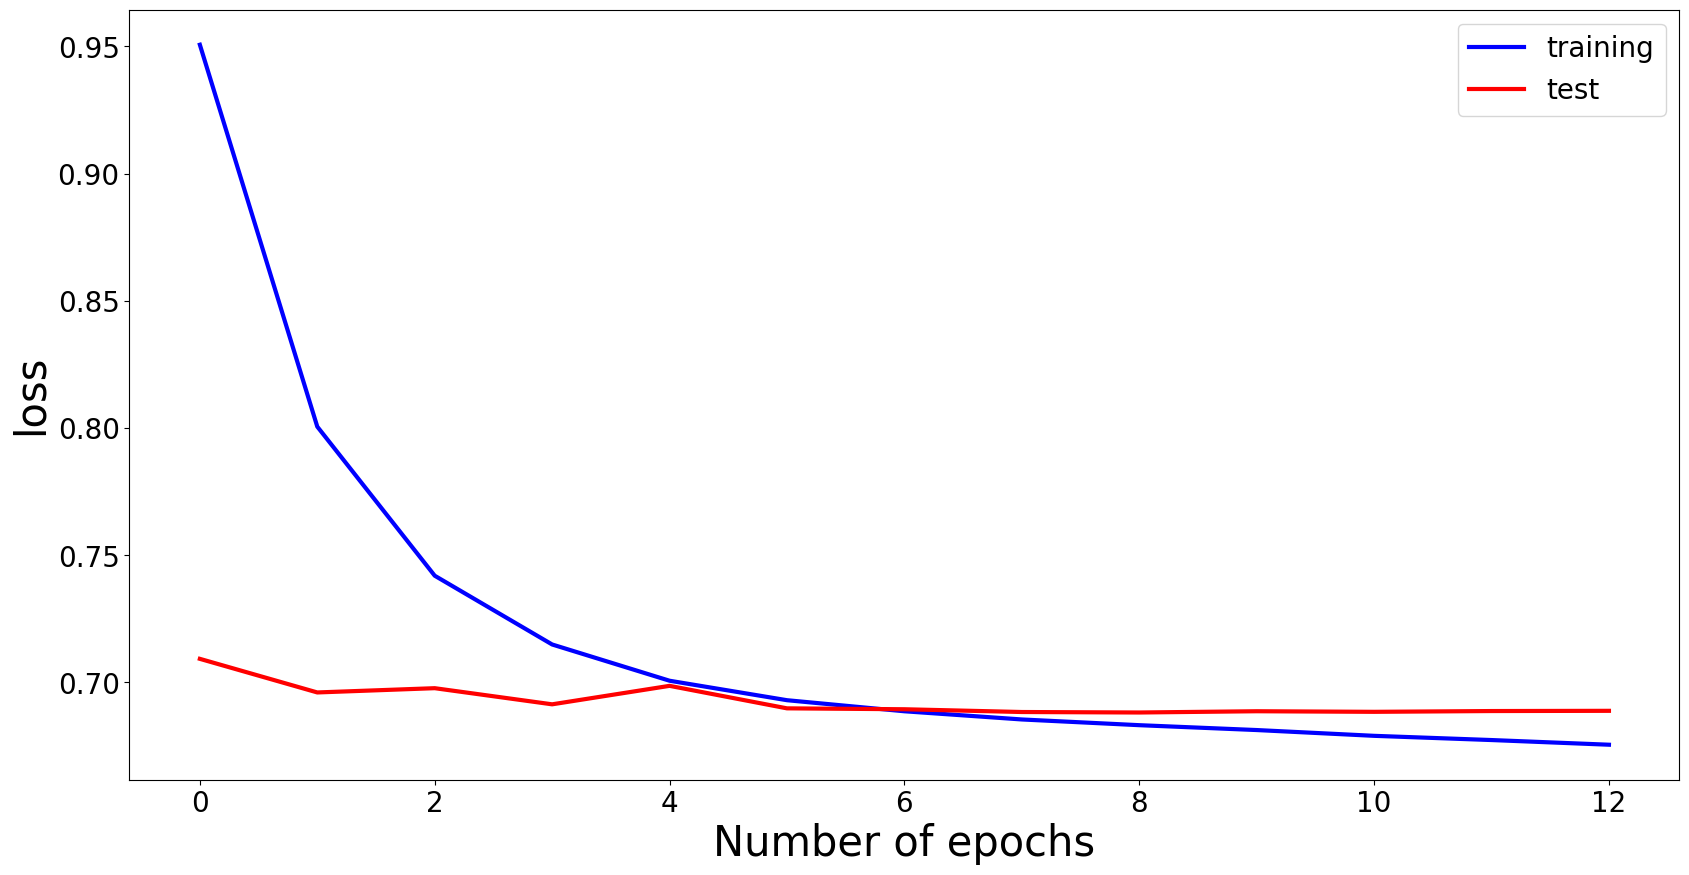

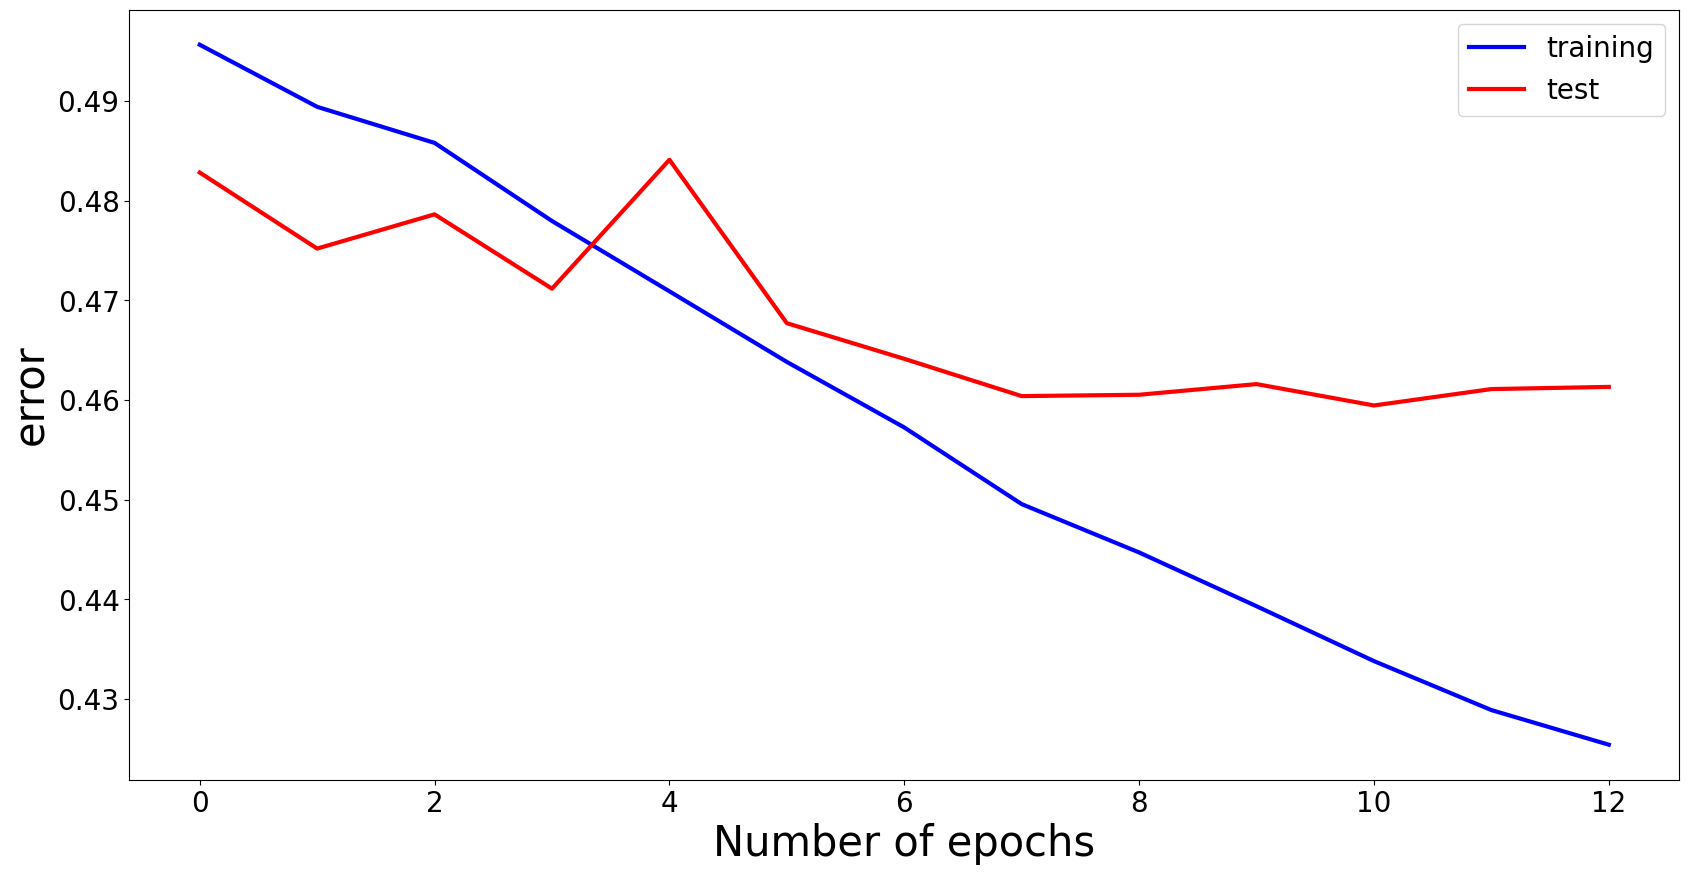

In [51]:
# Plot the graph
plot(log, './20250418/')
plt.show()